In [1]:
import cf_xarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xcmocean
import cmocean.cm as cmo
import extract_model as em

# Generically access model output

## MOM6

In [2]:
url = '/Users/kthyng/Downloads/20111231.ocean_daily.nc'
ds = xr.open_dataset(url)
ds = ds.cf.guess_coord_axis()  # setup for success with cf-xarray

### grid point

#### horizontal interp, vertical and time isel

In [3]:
varname = 'uo'  # this name should match the custom_criteria for xarray (see __init__)

# sel
longitude = float(ds[varname].cf['X'][0])
latitude = float(ds[varname].cf['Y'][0])
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds['uo'], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


#### horizontal and vertical interp, time isel

In [4]:
varname = 'uo'

# sel
longitude = float(ds[varname].cf['X'][0])
latitude = float(ds[varname].cf['Y'][0])
Z = float(ds[varname].zl[0])
sel = dict(longitude=longitude, latitude=latitude, Z=Z)

# isel
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, Z=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


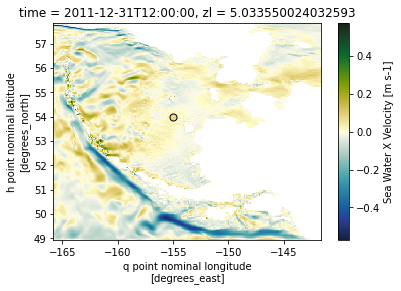

In [5]:
varname = 'uo'

# sel
longitude = -155
latitude = 54
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min(), vmax=dacheck.max(), cmap=cmap, edgecolors='k')

#### outside domain

Don't extrapolate

In [6]:
varname = 'uo'

# sel
longitude = -166
latitude = 48
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

em.select(**kwargs)

AssertionError: the input longitude range is outside the model domain

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


(-167.0, -143.0)

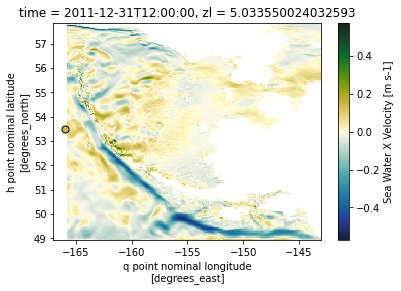

In [7]:
varname = 'uo'

# sel
longitude = -166
latitude = 53.5
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=True)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min(), vmax=dacheck.max(), cmap=cmap, edgecolors='k')

ax.set_xlim(-167,-143)

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [8]:
varname = 'uo'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['X'][::20].values
latitude = ds[varname].cf['Y'][::24].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, locstream=True)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of known locations

In [9]:
varname = 'uo'

# sel
longitude = ds[varname].cf['X'][:5]
latitude = ds[varname].cf['Y'][:6]
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


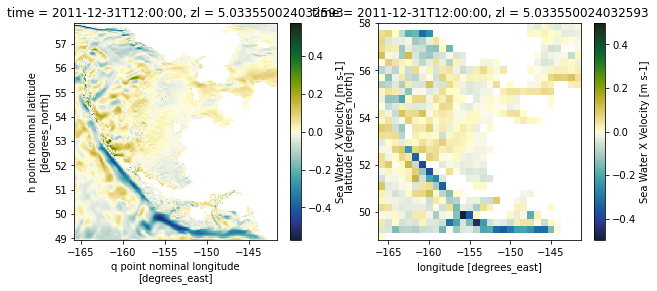

In [10]:
varname = 'uo'

# sel
longitude = np.linspace(ds[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False, extrap_val=np.nan)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## HYCOM

In [11]:
url = '/Users/kthyng/Downloads/hycom.nc'
xrargs = {'decode_times': False}
ds = xr.open_dataset(url, **xrargs)

### grid point

In [12]:
varname = 'water_u'

# sel
longitude = float(ds[varname].cf['X'][100])
latitude = float(ds[varname].cf['Y'][150])
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = None
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


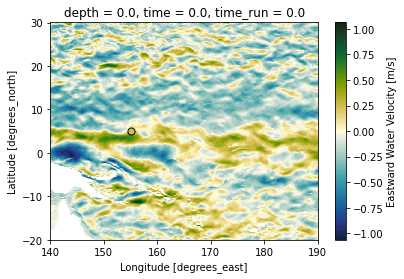

In [13]:
varname = 'water_u'

# sel
longitude = 155
latitude = 5
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = None
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min(), vmax=dacheck.max(), cmap=cmap, edgecolors='k')

#### outside domain

Don't extrapolate

In [14]:
varname = 'water_u'

# sel
longitude = -166
latitude = 48
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

da_out = em.select(**kwargs)
da_out

AssertionError: the input longitude range is outside the model domain

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


(138.0, 190.0)

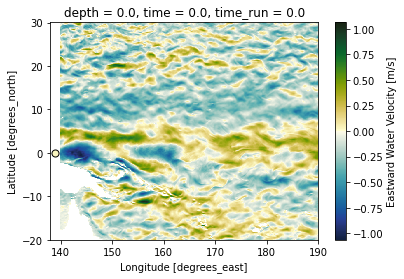

In [15]:
varname = 'water_u'

# sel
longitude = 139
latitude = 0
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = None
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=True)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.plot(ax=ax)
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min(), vmax=dacheck.max(), cmap=cmap, edgecolors='k')

ax.set_xlim(138,190)

### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [16]:
varname = 'water_u'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds[varname].cf['X'][::40].values
latitude = ds[varname].cf['Y'][::80].values
# selecting individual lon/lat locations with advanced xarray indexing
sel = dict(longitude=xr.DataArray(longitude, dims="pts"), latitude=xr.DataArray(latitude, dims="pts"))

# isel
Z = 0
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iZ=Z, locstream=True)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of known locations

In [17]:
varname = 'water_u'

# sel
longitude = ds[varname].cf['X'][100::500]
latitude = ds[varname].cf['Y'][100::500]
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = None
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1343: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/cf_xarray/accessor.py:1343: UserWarning: Variables {''} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


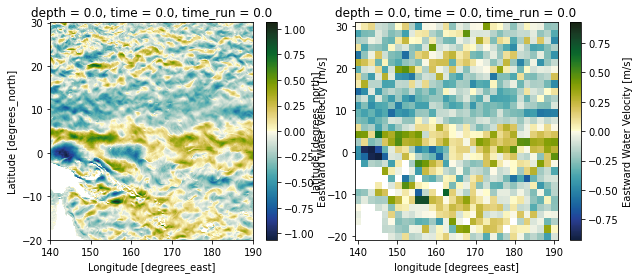

In [18]:
varname = 'water_u'

# sel
longitude = np.linspace(ds[varname].cf['X'].min(), ds.cf[varname].cf['X'].max(), 30)
latitude = np.linspace(ds[varname].cf['Y'].min(), ds.cf[varname].cf['Y'].max(), 30)
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = None
isel = dict(Z=Z)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.plot(ax=axes[0])
da_out.cmo.plot(ax=axes[1])


## ROMS

In [19]:
# open an example dataset from xarray's tutorials
ds = xr.tutorial.open_dataset('ROMS_example.nc', chunks={'ocean_time': 1})
xrargs = {}
ds.zeta.attrs['standard_name'] = 'sea_surface_elevation'
for dim, ax in zip(['xi_rho', 'eta_rho', 'ocean_time'],['X','Y','T']):
    ds[dim] = (dim, np.arange(ds.sizes[dim]), {"axis": ax})
ds.ocean_time.attrs["standard_name"] = "time"

### grid point

In [20]:
varname = 'zeta'

# sel
j, i = 50, 10
longitude = float(ds[varname].cf['longitude'][j,i])
latitude = float(ds[varname].cf['latitude'][j,i])

# isel
Z = None
T = 0
isel = dict(T=T,X=i, Y=j)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### not grid point

#### inside domain

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


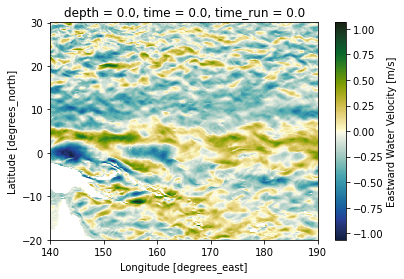

In [21]:
varname = 'zeta'

# sel
longitude = -91.5
latitude = 28.5

# isel
Z = None
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

da_out = em.select(**kwargs)

# plot
cmap = ds[varname].cmo.seq
dscheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')

#### outside domain

Don't extrapolate

In [22]:
varname = 'zeta'

# sel
longitude = -166
latitude = 48
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = 0
T = 0
isel = dict(Z=Z, T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False)

da_out = em.select(**kwargs)
da_out

AssertionError: the input longitude range is outside the model domain

Extrapolate

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


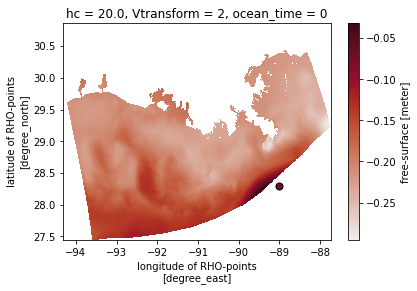

In [23]:
varname = 'zeta'

# sel
longitude = -89
latitude = 28.3
sel = dict(longitude=longitude, latitude=latitude)

# isel
Z = None
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=True)

da_out = em.select(**kwargs)

# plot
cmap = ds[varname].cmo.seq
dacheck = ds[varname].cf.isel(isel)
fig, ax = plt.subplots(1,1)
dacheck.cmo.cfplot(ax=ax, x='longitude', y='latitude')
ax.scatter(da_out.cf['longitude'], da_out.cf['latitude'], s=50, c=da_out, 
           vmin=dacheck.min().values, vmax=dacheck.max().values, cmap=cmap, edgecolors='k')


### points (locstream)

Unstructured pairs of lon/lat locations instead of grids of lon/lat locations, using `locstream`.

In [24]:
varname = 'zeta'

# sel
# this creates 12 pairs of lon/lat points that 
# align with grid points so we can check the 
# interpolation
longitude = ds.cf[varname].cf['longitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
latitude = ds.cf[varname].cf['latitude'].isel(eta_rho=60, xi_rho=slice(None,None,10))
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
Z = None
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, locstream=True)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.isel(isel).cf.sel(sel)

assert np.allclose(da_out, da_check, equal_nan=True)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of known locations

In [25]:
varname = 'zeta'

# sel
longitude = ds[varname].cf['longitude'][:-50:20,:-200:100]
latitude = ds[varname].cf['latitude'][:-50:20,:-200:100]
sel = dict(X=longitude.xi_rho, Y=longitude.eta_rho)

# isel
Z = None
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z)

da_out = em.select(**kwargs)

# check
da_check = ds[varname].cf.sel(sel).cf.isel(isel)

assert np.allclose(da_out, da_check)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### grid of new locations

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


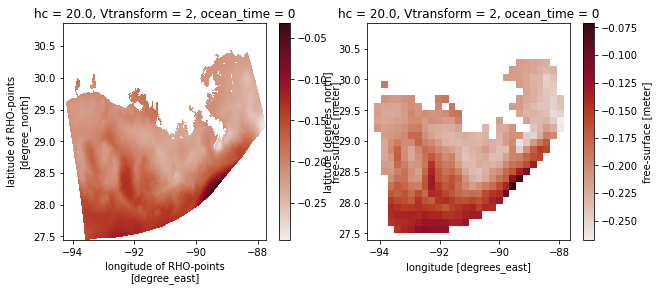

In [26]:
varname = 'zeta'

# sel
longitude = np.linspace(ds[varname].cf['longitude'].min(), ds.cf[varname].cf['longitude'].max(), 30)
latitude = np.linspace(ds[varname].cf['latitude'].min(), ds.cf[varname].cf['latitude'].max(), 30)

# isel
Z = None
T = 0
isel = dict(T=T)

kwargs = dict(da=ds[varname], longitude=longitude, latitude=latitude, iT=T, iZ=Z, extrap=False, extrap_val=np.nan)

da_out = em.select(**kwargs)

# plot
cmap = cmo.delta
dacheck = ds[varname].cf.isel(isel)

fig, axes = plt.subplots(1,2, figsize=(10,4))
dacheck.cmo.cfplot(ax=axes[0], x='longitude', y='latitude')
da_out.cmo.cfplot(ax=axes[1], x='longitude', y='latitude')
